# 探索基因的海洋：迷你序列搜索引擎（GeneSearch Lab）

本 notebook 以 Nature（2025）论文 **“Efficient and accurate search in petabase-scale sequence repositories”** 为背景，带你体验“**把海量序列库做成可检索的搜索引擎**”的核心思想：将 DNA 序列拆分成短片段（**k-mer**）作为特征，建立索引结构，让查询不再需要从头扫描全部数据，而是像搜索引擎一样快速召回候选并进行判别。

## 为什么要做序列搜索？

公共序列库（如 ENA/SRA 等）增长极快，但“让所有序列都能像网页一样被检索”并不容易。论文展示了如何在超大规模序列仓库上实现**高效、准确的序列搜索**，并基于 MetaGraph 框架构建可扩展的索引与查询流程。

---
本实验包含四个关键环节：
1. **特征化（k-mer）**：把 DNA 序列切成可检索的短片段  
2. **索引（倒排表）**：建立 k-mer → 序列ID 的映射以加速检索  
3. **查询与判别**：计算命中比例（match fraction）并用阈值过滤  
4. **误差与鲁棒性**：通过点突变实验观察假阳性（FP）与漏检（FN）的变化，并进行可视化分析

输出将自动保存到 `jobname_hash/` 文件夹，并提供打包下载，便于课堂汇报与作业提交。


论文链接：[Nature](https://www.nature.com/articles/s41586-025-09603-w)，[MetaGraph](https://github.com/ratschlab/metagraph)

In [1]:
#@title  基础设置（Basic settings / 必填参数）
#@markdown 这部分相当于“你要在数据库里找什么 + 这次实验叫什么”。
#@markdown - `query_sequence`：你要搜索的 DNA 片段（该版本目前只支持 A/C/G/T）。
#@markdown - `jobname`：任务名（建议“姓名缩写_实验编号”，例如 `dylan_lab1`，方便管理结果）。
#@markdown
#@markdown **课堂建议：**
#@markdown - 第一次尝试：保持默认先跑通流程。
#@markdown - 之后再调 `k`、`threshold` 做对比实验。

import os, re, hashlib

query_sequence = "ACGTTGCAACGTTGCAACGTGATCCGTAAG"  #@param {type:"string"}
jobname = "test"  #@param {type:"string"}

#@markdown **输入规范（重要）：**
#@markdown - 不要有空格/换行（程序会自动去掉，但建议输入干净）
#@markdown - 只允许 A/C/G/T（教学版；如需支持 N 可扩展）

query_sequence = re.sub(r"\s+", "", query_sequence).upper()
if not set(query_sequence).issubset(set("ACGT")):
    raise ValueError("query_sequence 只能包含 A/C/G/T（教学版）。")

def add_hash(name, seq, n=5):
    h = hashlib.sha1(seq.encode()).hexdigest()[:n]
    safe = re.sub(r"[^a-zA-Z0-9_\-]+", "_", name).strip("_")
    return f"{safe}_{h}"

jobdir = add_hash(jobname, query_sequence)
os.makedirs(jobdir, exist_ok=True)

print("结果将保存到文件夹：", jobdir)
print("query 长度：", len(query_sequence))

结果将保存到文件夹： test_e66f1
query 长度： 30


In [ ]:
#@title  检索设置（Search settings / 核心参数）
#@markdown 这部分复现“智能检索”的关键思想：**k-mer 特征 + 阈值判别**。
#@markdown
#@markdown ### k（k-mer 长度）
#@markdown - `k` 越小：特征短，更容易“撞车”→ **假阳性 FP 增加**
#@markdown - `k` 越大：特征长，更精确→ **FP 降低**，但对突变更敏感→ **漏检 FN 可能增加**
#@markdown
#@markdown ### threshold（命中阈值）
#@markdown - 我们给每条候选序列一个分数：`frac = 命中query_kmers数量 / query_kmers总数`
#@markdown - 阈值越高：越严格 → FP 降低，但 FN 可能上升
#@markdown
#@markdown **课堂建议：**
#@markdown - 快速尝试：`k=11`，`threshold=0.2`
#@markdown - 对比实验：`k=7/11/15`，阈值试 `0.1/0.2/0.3`

k = 15  #@param {type:"integer"}
threshold = 0.3  #@param {type:"number"}

In [ ]:
#@title  数据库生成设置（Database settings / 控制实验难度）
#@markdown 这部分决定“迷你序列库”的规模与难度（相当于课堂版的公共序列仓库）。
#@markdown
#@markdown - `num_sequences`：数据库序列条数（越大越像真实“海量库”）
#@markdown - `seq_length`：每条序列长度（越长，k-mer 更多）
#@markdown - `num_true_hits`：真正包含 query 的序列数（真阳性数量）
#@markdown - `seed`：随机种子（同一 seed 让同学得到同样数据，便于对比）
#@markdown
#@markdown **课堂建议：**
#@markdown - 演示：30 条、每条 120bp、真阳性 6 条
#@markdown - 分组竞赛：80~120 条

num_sequences = 500  #@param {type:"integer"}
seq_length = 400  #@param {type:"integer"}
num_true_hits = 10  #@param {type:"integer"}
seed = 42  #@param {type:"integer"}

In [ ]:
#@title  噪声与鲁棒性（Mutation / Error robustness）
#@markdown 真实世界里会有突变/测序误差。我们用“点突变（单碱基替换）”模拟。
#@markdown - 开启后，会对 query 做 `mutation_count` 次随机替换，并对比突变前后 TP/FP/FN。
#@markdown
#@markdown **课堂建议：**
#@markdown - 第一次先关闭
#@markdown - 后续开启（误差、假阳性、速度/准确权衡）

introduce_mutation = True  #@param {type:"boolean"}
mutation_count = 2  #@param {type:"integer"}

In [ ]:
#@title  输出与下载（Save & Download）
#@markdown 这部分控制保存哪些文件，以及是否打包下载。
#@markdown
#@markdown - `save_csv`：保存每条候选的分数（便于写报告/复现）
#@markdown - `save_plots`：保存图（课堂投屏/海报）
#@markdown - `zip_results`：把整个结果目录打包为 zip（方便学生提交）
#@markdown - `auto_download_zip`：在 Colab 里自动触发下载
#@markdown - `dpi`：图片清晰度

save_csv = True  #@param {type:"boolean"}
save_plots = True  #@param {type:"boolean"}
zip_results = True  #@param {type:"boolean"}
auto_download_zip = True  #@param {type:"boolean"}
dpi = 200  #@param {type:"integer"}

In [ ]:
#@title  运行提示（How to run）
#@markdown **操作顺序：**
#@markdown 1. 先在上面表单里填参数（或保持默认）
#@markdown 2. 点击菜单 `Runtime` → `Run all`
#@markdown 3. 结果会写入 `jobname_hash/` 目录：db.fa、query.fa、result.csv、metrics.txt、plots/
#@markdown
#@markdown **课堂建议：**
#@markdown - 第一次：先不改参数，跑通并看图
#@markdown - 然后做对比：改 `k`（7/11/15）或改 `threshold`（0.1/0.2/0.3）
print("准备就绪：请继续运行后面的“生成数据→建索引→查询→评估→可视化”代码单元。")

准备就绪：请继续运行后面的“生成数据→建索引→查询→评估→可视化”代码单元。


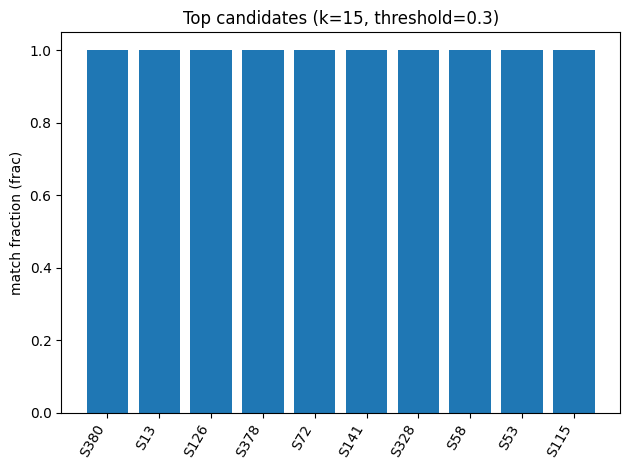

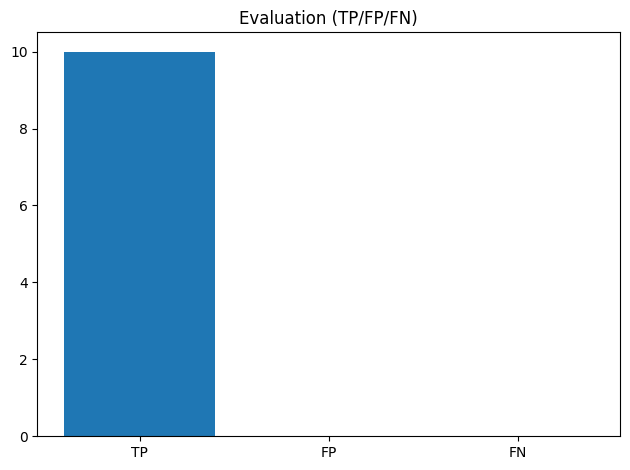

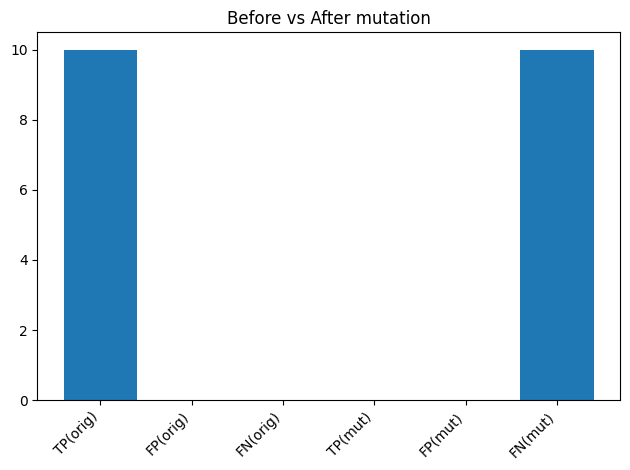

 已打包： /content/test_e66f1/results.zip

=== 本次实验总结 ===
保存目录： test_e66f1
TP/FP/FN = 10 0 0
真阳性： ['S115', 'S126', 'S13', 'S141', 'S328', 'S378', 'S380', 'S53', 'S58', 'S72']
预测命中： ['S115', 'S126', 'S13', 'S141', 'S328', 'S378', 'S380', 'S53', 'S58', 'S72']
突变位点： [(14, 'C', 'A'), (15, 'A', 'G')]
突变后 TP/FP/FN = 0 0 10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title  运行实验（Generate → Index → Query → Evaluate → Visualize → Zip/Download）
#@markdown 这一格会完成整个“智能检索”流程，并把结果写入 `jobname_hash/`。
#@markdown
#@markdown **输出文件：**
#@markdown - `db.fa`：数据库序列（模拟公共序列库）
#@markdown - `query.fa`：查询序列
#@markdown - `result.csv`：每条候选序列的得分（如果 save_csv=True）
#@markdown - `metrics.txt`：TP/FP/FN 等指标
#@markdown - `plots/*.png`：可视化图片（如果 save_plots=True）
#@markdown - `results.zip`：打包文件（如果 zip_results=True）

import random, csv, shutil
from collections import defaultdict
import matplotlib.pyplot as plt

# ---------- 基础工具 ----------
DNA = "ACGT"

def random_dna(n):
    return "".join(random.choice(DNA) for _ in range(n))

def kmers(seq, kk):
    return [seq[i:i+kk] for i in range(len(seq)-kk+1)]

def write_fasta(records, path):
    with open(path, "w") as f:
        for name, seq in records:
            f.write(f">{name}\n{seq}\n")

def mutate_substitution(seq):
    pos = random.randrange(len(seq))
    old = seq[pos]
    choices = [b for b in DNA if b != old]
    new = random.choice(choices)
    return seq[:pos] + new + seq[pos+1:], pos, old, new

def build_kmer_index(db_records, kk):
    index = defaultdict(set)
    db_kmer_sets = {}
    for sid, seq in db_records:
        s_kmers = set(kmers(seq, kk))
        db_kmer_sets[sid] = s_kmers
        for x in s_kmers:
            index[x].add(sid)
    return index, db_kmer_sets

def query_index(q_seq, kk, index, db_kmer_sets):
    qk = set(kmers(q_seq, kk))
    candidates = set()
    for x in qk:
        candidates |= index.get(x, set())
    results = []
    for sid in candidates:
        hit = len(qk & db_kmer_sets[sid])
        frac = hit / len(qk) if len(qk) else 0.0
        results.append((sid, hit, len(qk), frac))
    results.sort(key=lambda t: t[3], reverse=True)
    return results

def evaluate(true_ids, pred_ids):
    tp = len(true_ids & pred_ids)
    fp = len(pred_ids - true_ids)
    fn = len(true_ids - pred_ids)
    return tp, fp, fn

# ---------- 1) 生成数据库 ----------
random.seed(seed)
all_ids = [f"S{i+1:02d}" for i in range(num_sequences)]
true_hit_ids = set(random.sample(all_ids, min(num_true_hits, num_sequences)))

db = []
for sid in all_ids:
    seq = random_dna(seq_length)
    if sid in true_hit_ids and len(query_sequence) < seq_length:
        insert_pos = random.randrange(0, seq_length - len(query_sequence))
        seq = seq[:insert_pos] + query_sequence + seq[insert_pos+len(query_sequence):]
    db.append((sid, seq))

# 保存 fasta
write_fasta(db, os.path.join(jobdir, "db.fa"))
write_fasta([("Q1", query_sequence)], os.path.join(jobdir, "query.fa"))

# ---------- 2) 建索引 ----------
index, db_kmer_sets = build_kmer_index(db, k)

# ---------- 3) 查询 ----------
results = query_index(query_sequence, k, index, db_kmer_sets)
hits = [r for r in results if r[3] >= threshold]
pred_hit_ids = set([sid for sid, *_ in hits])

# ---------- 4) 评估 ----------
tp, fp, fn = evaluate(true_hit_ids, pred_hit_ids)

# 保存 metrics
with open(os.path.join(jobdir, "metrics.txt"), "w") as f:
    f.write(f"jobdir: {jobdir}\n")
    f.write(f"k: {k}\nthreshold: {threshold}\n")
    f.write(f"num_sequences: {num_sequences}, seq_length: {seq_length}, num_true_hits: {num_true_hits}\n")
    f.write(f"TP: {tp}, FP: {fp}, FN: {fn}\n")
    f.write(f"true_hit_ids: {sorted(true_hit_ids)}\n")
    f.write(f"pred_hit_ids: {sorted(pred_hit_ids)}\n")

# 保存 result.csv
if save_csv:
    with open(os.path.join(jobdir, "result.csv"), "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["sid", "hit_kmers", "total_query_kmers", "frac", "is_true_hit"])
        for sid, hit, total, frac in results:
            w.writerow([sid, hit, total, frac, int(sid in true_hit_ids)])

# ---------- 5) 可视化 ----------
plots_dir = os.path.join(jobdir, "plots")
if save_plots:
    os.makedirs(plots_dir, exist_ok=True)

    # (A) Top 候选条形图（分数最高的前 20）
    top = results[:20]
    plt.figure()
    plt.bar([x[0] for x in top], [x[3] for x in top])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("match fraction (frac)")
    plt.title(f"Top candidates (k={k}, threshold={threshold})")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "top_candidates.png"), dpi=dpi)
    plt.show()

    # (B) TP/FP/FN 柱状图（单次实验）
    plt.figure()
    plt.bar(["TP", "FP", "FN"], [tp, fp, fn])
    plt.title("Evaluation (TP/FP/FN)")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "tp_fp_fn.png"), dpi=dpi)
    plt.show()

# ---------- 6) 突变实验 ----------
mutation_report = None
if introduce_mutation and mutation_count > 0:
    mut_seq = query_sequence
    changes = []
    random.seed(seed + 999)  # 让突变也可复现
    used_positions = set()  # 记录已经突变过的位置（防止重复）

    def mutate_substitution_no_repeat(seq, used_positions):
        candidates = [i for i in range(len(seq)) if i not in used_positions]
        if not candidates:
            return seq, None, None, None
        pos = random.choice(candidates)
        used_positions.add(pos)

        old = seq[pos]
        choices = [b for b in "ACGT" if b != old]
        new = random.choice(choices)
        return seq[:pos] + new + seq[pos+1:], pos, old, new

    for _ in range(mutation_count):
        mut_seq, pos, old, new = mutate_substitution_no_repeat(mut_seq, used_positions)
        if pos is None:
            break
        changes.append((pos, old, new))

    mut_results = query_index(mut_seq, k, index, db_kmer_sets)
    mut_hits = [r for r in mut_results if r[3] >= threshold]
    mut_pred_ids = set([sid for sid, *_ in mut_hits])
    mut_tp, mut_fp, mut_fn = evaluate(true_hit_ids, mut_pred_ids)

    mutation_report = (changes, mut_tp, mut_fp, mut_fn)

    with open(os.path.join(jobdir, "mutation.txt"), "w") as f:
        f.write(f"mutations: {changes}\n")
        f.write(f"mut_seq: {mut_seq}\n")
        f.write(f"TP: {mut_tp}, FP: {mut_fp}, FN: {mut_fn}\n")
        f.write(f"pred_hit_ids_mut: {sorted(mut_pred_ids)}\n")

    if save_plots:
        plt.figure()
        plt.bar(["TP(orig)", "FP(orig)", "FN(orig)", "TP(mut)", "FP(mut)", "FN(mut)"],
                [tp, fp, fn, mut_tp, mut_fp, mut_fn])
        plt.xticks(rotation=45, ha="right")
        plt.title("Before vs After mutation")
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "mutation_compare.png"), dpi=dpi)
        plt.show()

# ---------- 7) 打包 & 下载 ----------
zip_path = None
if zip_results:
    zip_path = shutil.make_archive(base_name=os.path.join(jobdir, "results"),
                                   format="zip",
                                   root_dir=jobdir)
    print(" 已打包：", zip_path)

print("\n=== 本次实验总结 ===")
print("保存目录：", jobdir)
print("TP/FP/FN =", tp, fp, fn)
print("真阳性：", sorted(true_hit_ids))
print("预测命中：", sorted(pred_hit_ids))

if mutation_report:
    changes, mut_tp, mut_fp, mut_fn = mutation_report
    print("突变位点：", changes)
    print("突变后 TP/FP/FN =", mut_tp, mut_fp, mut_fn)

# Colab 一键下载
if auto_download_zip and zip_path is not None:
    try:
        from google.colab import files
        files.download(zip_path)
    except Exception as e:
        print("（提示）当前环境不是 Colab 或下载触发失败，你仍可在左侧文件栏手动下载：", zip_path)